In [21]:
import numpy as np
import random
from qiskit import *
from qiskit import IBMQ, Aer, assemble, transpile
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.visualization import plot_state_city
from ibm_quantum_widgets import *

In [22]:
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error

def get_noise(p):

    error_meas = pauli_error([('X',p), ('I', 1 - p)])

    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_meas, "measure") # measurement error is applied to measurements
        
    return noise_model

In [23]:
#條誇號參數絕定其error
noise_model = get_noise(0.01)

In [24]:
def diffuser(n):
    qc = QuantumCircuit(n)
    for qubit in range(n):
        qc.h(qubit)
    for qubit in range(n):
        qc.x(qubit)
    qc.h(n-1)
    qc.mct(list(range(n-1)), n-1)
    qc.h(n-1)
    
    for qubit in range(n):
        qc.x(qubit)
    for qubit in range(n):
        qc.h(qubit)
    
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    return U_s

In [25]:
def vertexcolor_oracle(qc, v_list, e_list):
    #qc.x(in_qubits_v[3])
    #qc.x(in_qubits_v[4])
    #qc.x(in_qubits_v[7])


    for j in range(3*len(e_list)):
        qc.x(ax_qubits_e[j])
    for j in range(len(v_list)):
        qc.x(check4_qubits[j])

    #check two number are not same
    i = 0
    for e in e_list:
        qc.cx(in_qubits_v[2*e[0]], ax_qubits_e[i])
        qc.cx(in_qubits_v[2*e[1]], ax_qubits_e[i])
        qc.barrier()
        qc.cx(in_qubits_v[2*e[0]+1], ax_qubits_e[i+1])
        qc.cx(in_qubits_v[2*e[1]+1], ax_qubits_e[i+1])
        qc.barrier()
        qc.ccx(ax_qubits_e[i], ax_qubits_e[i+1], ax_qubits_e[i+2])
        qc.barrier()
        i += 3


    #check the number is not 4
    for j in range(len(v_list)):
        qc.ccx(in_qubits_v[2*j], in_qubits_v[2*j+1], check4_qubits[j])
    qc.barrier()


    #target
    check_qubitslist = []
    for j in range(len(e_list)):
        check_qubitslist.append(ax_qubits_e[j*3+2])
    for j in range(len(v_list)):
        check_qubitslist.append(check4_qubits[j])
    qc.mct(check_qubitslist, target[0])
    qc.barrier()

    #reverse part

    #check the number is not 4
    for j in range(len(v_list)):
        qc.ccx(in_qubits_v[2*j], in_qubits_v[2*j+1], check4_qubits[j])
    qc.barrier()

    #check two number are not same
    e_list_r = e_list[::-1]
    i = 3*(len(e_list) - 1)
    for e in e_list_r:
        qc.ccx(ax_qubits_e[i], ax_qubits_e[i+1], ax_qubits_e[i+2])
        qc.barrier()
        qc.cx(in_qubits_v[2*e[0]+1], ax_qubits_e[i+1])
        qc.cx(in_qubits_v[2*e[1]+1], ax_qubits_e[i+1])
        qc.barrier()
        qc.cx(in_qubits_v[2*e[0]], ax_qubits_e[i])
        qc.cx(in_qubits_v[2*e[1]], ax_qubits_e[i])
        qc.barrier()
        i -= 3

    for j in range(3*len(e_list)):
        qc.x(ax_qubits_e[j])
    for j in range(len(v_list)):
        qc.x(check4_qubits[j])
    qc.barrier()

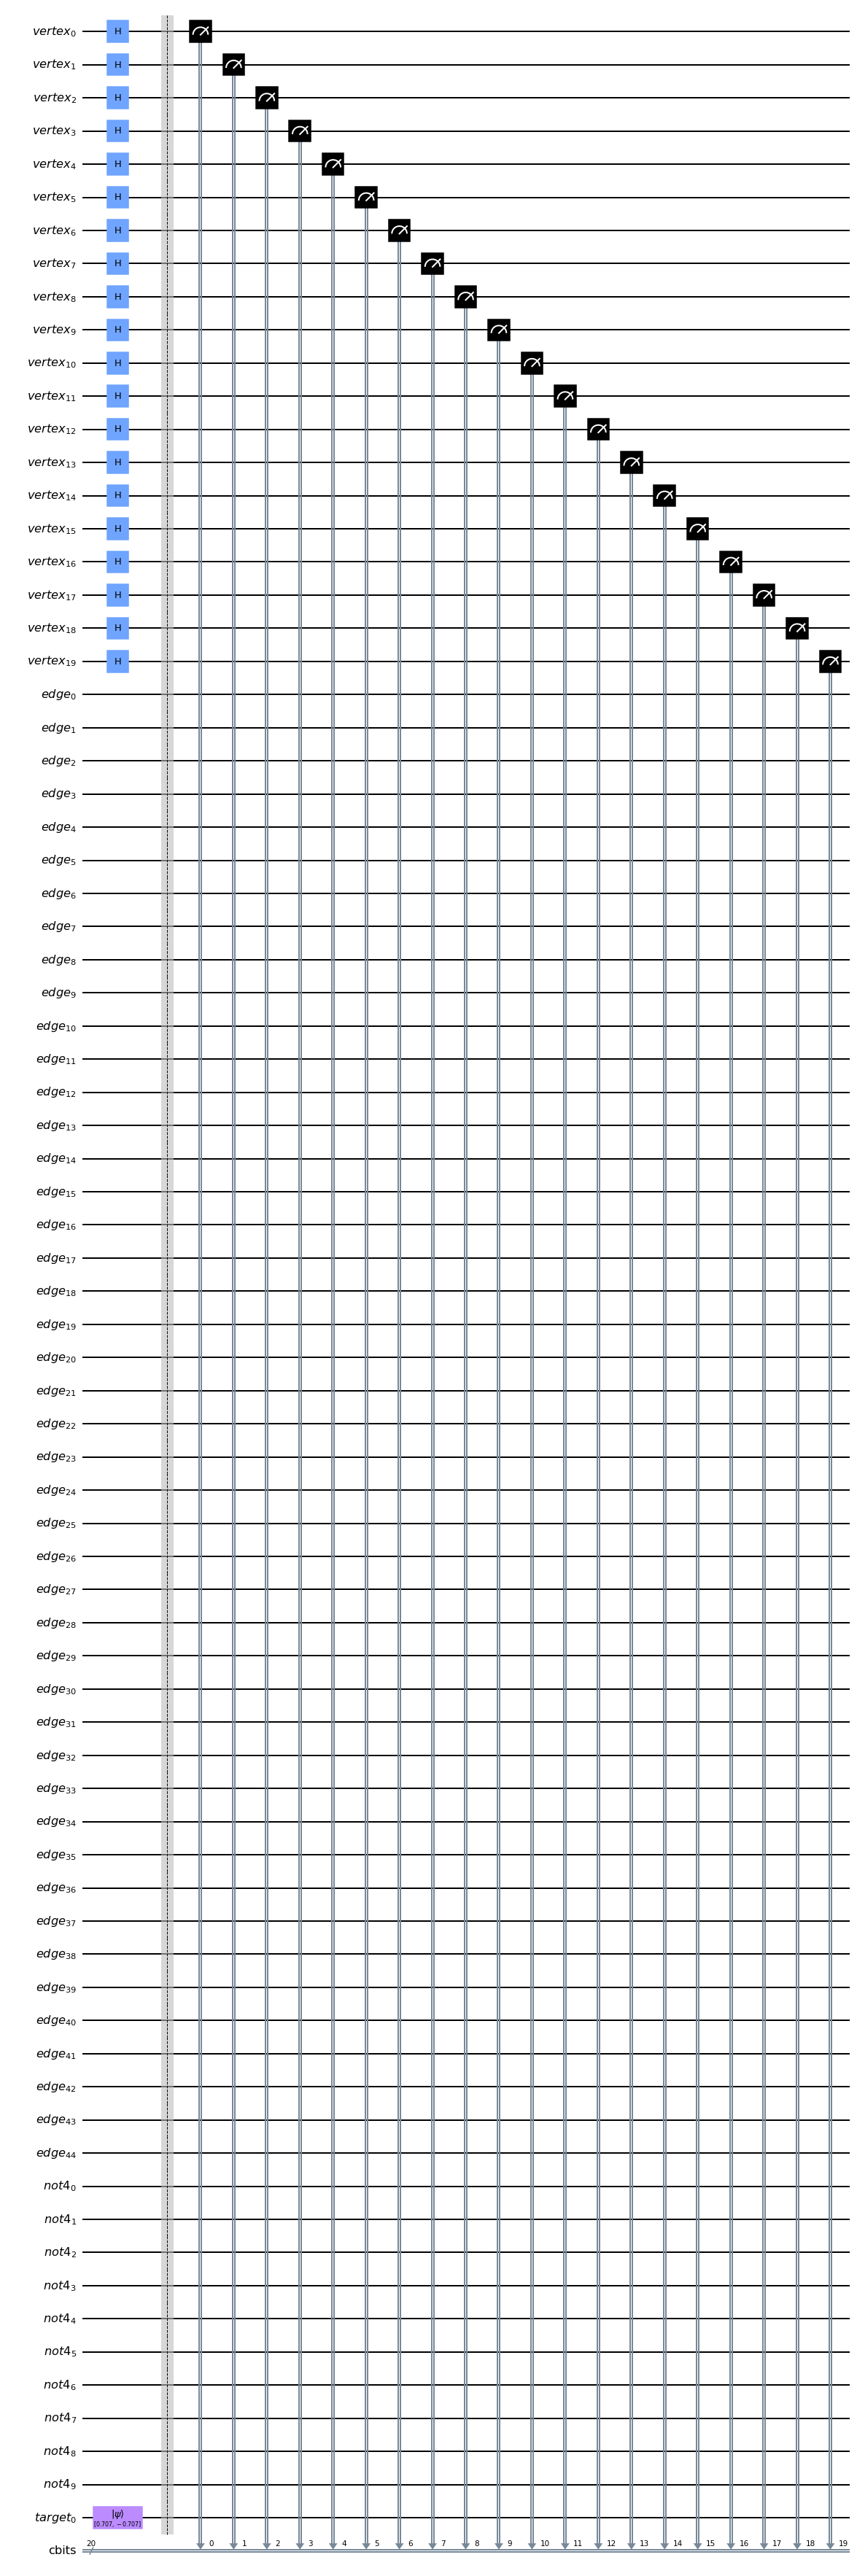

In [26]:
#example (v為vertex, e為edge)
# ex 1 
#v_list = [0,1,2,3,4]
#e_list = [[0,1],[1,2],[1,3], [1,4]]

# ex 2
v_list = [0,1,2,3,4,5,6,7,8,9]
e_list = [[0,1],[0,4],[0,5],[1,2],[1,6],[2,3],[2,7],[3,4],[3,8],[4,9],[5,7],[5,8],[6,8],[6,9],[7,9]]

#ex 3
#v_list = [0,1,2]
#e_list = [[0,1], [1,2]]

# choose n prob.
top_n = 9

#input vertex qubits
in_qubits_v = QuantumRegister(2*len(v_list), name = 'vertex')
#auxiliary qubits (edge)
ax_qubits_e = QuantumRegister(3*len(e_list), name = 'edge')
#因為這裡是做3-coloring，第四個顏色的答案要捨去
check4_qubits = QuantumRegister(len(v_list), name = 'not4')
#target qubit
target = QuantumRegister(1, name = 'target')
#cbit:輸出結果
cbits = ClassicalRegister(2*len(v_list), name = 'cbits')


qc = QuantumCircuit(in_qubits_v, ax_qubits_e, check4_qubits, target, cbits)

#initialize 'target' as |->
qc.initialize([1, -1]/np.sqrt(2), target)

#parallelization
qc.h(in_qubits_v)
qc.barrier()

#取的次數視情況而定，這裡取7
xx = random.randint(0,0)
for jj in range(xx):
    #oracle
    vertexcolor_oracle(qc, v_list, e_list)
    qc.barrier()

    #diffuser
    qc.append(diffuser(2*len(v_list)), list(range(2*len(v_list))))
    qc.barrier()

#可以自行決定要run幾次(每個例子都會有不一樣的最佳次數)


#measure
qc.measure(in_qubits_v, cbits)

qc.draw(output='mpl', fold = -1)

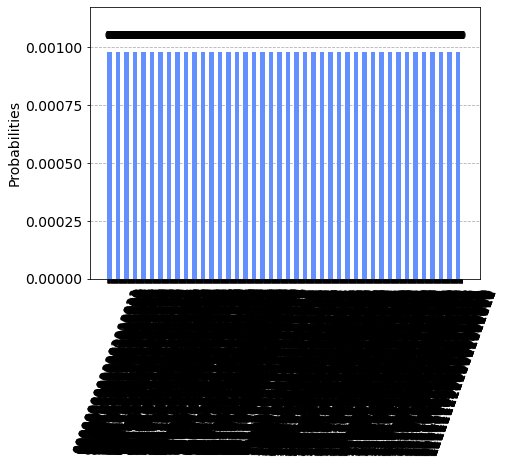

In [27]:
qasm_sim = Aer.get_backend('qasm_simulator')
transpiled_qc = transpile(qc, qasm_sim)
qobj = assemble(transpiled_qc)
result = qasm_sim.run(qobj).result()
counts = result.get_counts()
plot_histogram(counts)

[['00001011011011111110', 1], ['10110101101001110010', 1], ['10100000100011011110', 1], ['00111010111101000100', 1], ['01110000000111111011', 1], ['10101000100100111011', 1], ['00001010101000001001', 1], ['10001101101101011100', 1], ['10101001111001000001', 1], ['10000110011011000101', 1], ['11100111011000100100', 1], ['10101011010110010011', 1], ['10000111000101100011', 1], ['10100110100010010011', 1], ['11010100011011101001', 1], ['10010001100010110111', 1], ['00101110010001111011', 1], ['01010101011011111001', 1], ['01001100100101100100', 1], ['01110100110000110101', 1], ['01111110100111011000', 1], ['11000111100011000001', 1], ['10000011010011100000', 1], ['11101110100100110100', 1], ['00101101101100000000', 1], ['00100000000110110111', 1], ['10000000100001011000', 1], ['11111001101010011001', 1], ['11010100110101000100', 1], ['01010101010110011000', 1], ['10100011110110010011', 1], ['00011111000100001010', 1], ['00101111011011000000', 1], ['10101110101011000100', 1], ['11101110111

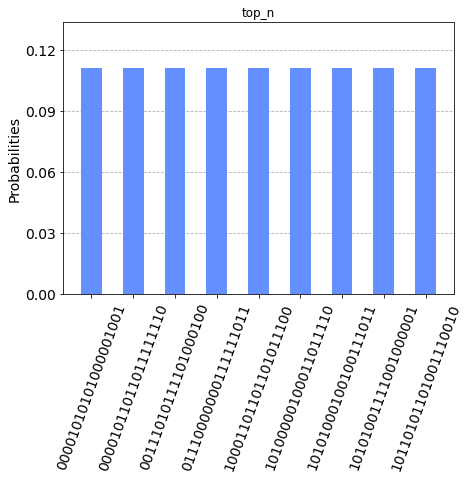

In [28]:
p1 = []
p2 = []
pause = result.get_counts()
pause.clear()
di = dict.fromkeys(counts)
for i in di.keys():
    p1.append([i,counts.get(i)])
p1.sort(key = lambda s: s[1],reverse = True)
print(p1)
for i in range(top_n):
        a = p1[i]
        pause.setdefault(a[0],a[1])
plot_histogram(pause, title="top_n",bar_labels = False)

In [29]:
print(counts)

{'00001011011011111110': 1, '10110101101001110010': 1, '10100000100011011110': 1, '00111010111101000100': 1, '01110000000111111011': 1, '10101000100100111011': 1, '00001010101000001001': 1, '10001101101101011100': 1, '10101001111001000001': 1, '10000110011011000101': 1, '11100111011000100100': 1, '10101011010110010011': 1, '10000111000101100011': 1, '10100110100010010011': 1, '11010100011011101001': 1, '10010001100010110111': 1, '00101110010001111011': 1, '01010101011011111001': 1, '01001100100101100100': 1, '01110100110000110101': 1, '01111110100111011000': 1, '11000111100011000001': 1, '10000011010011100000': 1, '11101110100100110100': 1, '00101101101100000000': 1, '00100000000110110111': 1, '10000000100001011000': 1, '11111001101010011001': 1, '11010100110101000100': 1, '01010101010110011000': 1, '10100011110110010011': 1, '00011111000100001010': 1, '00101111011011000000': 1, '10101110101011000100': 1, '11101110111010110011': 1, '10110010000001000010': 1, '11000100101101010100': 1, 

In [30]:
aer_sim = Aer.get_backend('qasm_simulator')

t_qc = transpile(qc, aer_sim)
qobj = assemble(t_qc, shots = 1000)
results = aer_sim.run(qobj, noise_model=noise_model, shots=1000).result()
noisy_counts = results.get_counts()
print(noisy_counts)

{'01110010010010111101': 1, '01001111000110000100': 1, '10000101011011100001': 1, '01000110011000111111': 1, '11000110100111111111': 1, '10101111000100011011': 1, '00100011111111110100': 1, '11110010100010011011': 1, '10010011011110000101': 1, '01111101100011010101': 1, '10110100000010110000': 1, '11001111110101010100': 1, '11000100111111010011': 1, '01111101001001100111': 1, '10101011100101111111': 1, '10001011000000100111': 1, '10001111111000111100': 1, '11110000111100011111': 1, '01000110001010011001': 1, '11110100111000101001': 1, '10000000110010000010': 1, '00111011010011100000': 1, '01100010111100011100': 1, '01100000110110010100': 1, '00100001101110000100': 1, '10011100111100100010': 1, '11100010001110101111': 1, '10101110000101000010': 1, '10100111010010100111': 1, '01000111000111000011': 1, '10111101000111001011': 1, '10101101001011101010': 1, '00001011001010110110': 1, '11110100110001100010': 1, '10010000010011101001': 1, '11101010010100000011': 1, '10010011011000010011': 1, 

[['01110010010010111101', 1], ['01001111000110000100', 1], ['10000101011011100001', 1], ['01000110011000111111', 1], ['11000110100111111111', 1], ['10101111000100011011', 1], ['00100011111111110100', 1], ['11110010100010011011', 1], ['10010011011110000101', 1], ['01111101100011010101', 1], ['10110100000010110000', 1], ['11001111110101010100', 1], ['11000100111111010011', 1], ['01111101001001100111', 1], ['10101011100101111111', 1], ['10001011000000100111', 1], ['10001111111000111100', 1], ['11110000111100011111', 1], ['01000110001010011001', 1], ['11110100111000101001', 1], ['10000000110010000010', 1], ['00111011010011100000', 1], ['01100010111100011100', 1], ['01100000110110010100', 1], ['00100001101110000100', 1], ['10011100111100100010', 1], ['11100010001110101111', 1], ['10101110000101000010', 1], ['10100111010010100111', 1], ['01000111000111000011', 1], ['10111101000111001011', 1], ['10101101001011101010', 1], ['00001011001010110110', 1], ['11110100110001100010', 1], ['10010000010

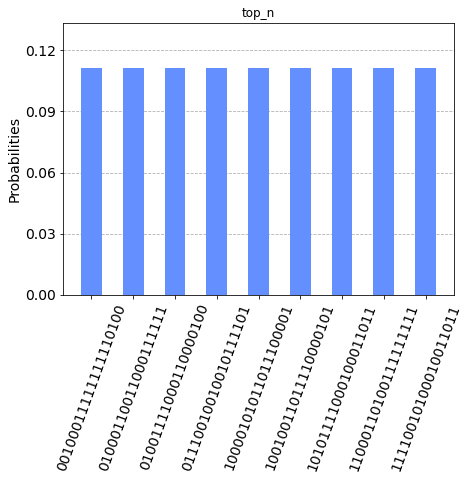

In [31]:
p3 = []
p4 = []
pause2 = results.get_counts()
pause2.clear()
di2 = dict.fromkeys(noisy_counts)
for i in di2.keys():
    p3.append([i,noisy_counts.get(i)])
p3.sort(key = lambda s: s[1],reverse = True)
print(p3)
for i in range(top_n):
        b = p3[i]
        pause2.setdefault(b[0],b[1])
plot_histogram(pause2, title="top_n",bar_labels = False)

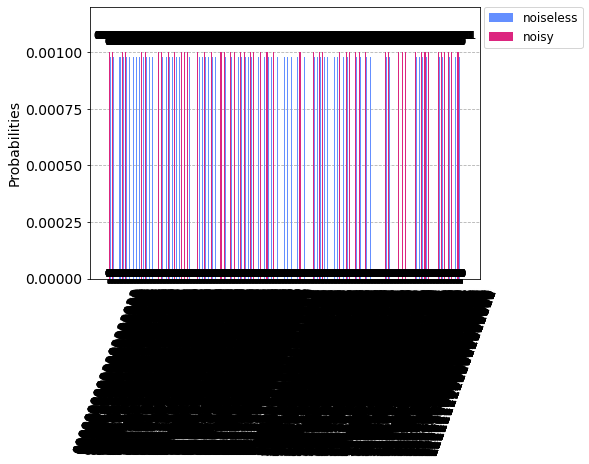

In [32]:
plot_histogram([counts, noisy_counts], legend=['noiseless', 'noisy'])

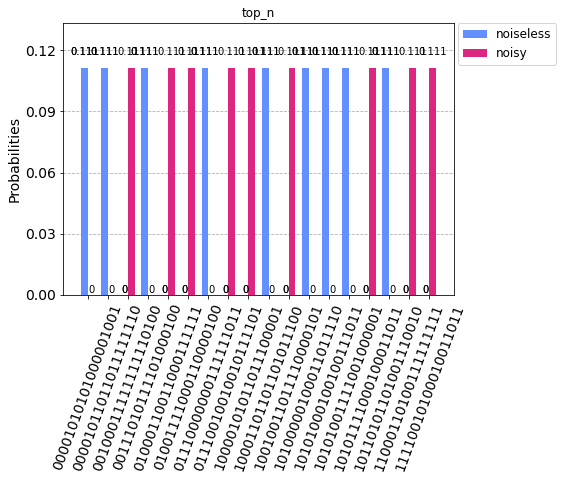

In [33]:
plot_histogram([pause, pause2], title="top_n", legend=['noiseless', 'noisy'])